# Causal Interpretation for Boston Housing Price

This notebook uses the popular kaggle Boston Housing dataset to showcase how we can interpret a blackbox model from both the **correlation and causation** perspective by leveraging the power of model interpretation tools like [SHAP](https://shap.readthedocs.io/en/latest/index.html) and [EconML](https://aka.ms/econml). This housing dataset collects median home values and neighborhood characteristics for the Boston area, largely from the 1970 U.S. Census. We start with a linear regression to build intuition. We then train a fine-tuned predictive ML model and use SHAP to better understand the correlations between features and target and which features are the strongest predictors. Finally, we train a separate causal model using EconML, which identifies features that have a **direct causal effect** on housing price, instead of just predicting the housing price given a set of characteristics.

It includes the following sections:
1. [A Gentle Start: Linear Regression](#A-Gentle-Start:-Linear-Regression)
2. [Train a Fine-tuned Predictive ML Model](#Train-a-Fine-tuned-Predictive-ML-Model)
3. [Correlation Interpretation](#Correlation-Interpretation)
    * Feature Importance -- Learn the top predictors for a given ML model
    * Partial Dependence Plot -- Learn the statistical relationship between share of Black residents and housing price
4. [Causal Interpretation](#Causal-Interpretation)
    * Direct Causal Effect -- Do the top predictors also have a direct effect on outcome of interest?
    * Segmentation -- How different type of houses respond differently to number of rooms?
    * What If Analysis -- How the overall housing price changes with one more room?

In [1]:
# Some imports to get us started
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

# A Gentle Start: Linear Regression

### Data Description

This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston Mass. 

Below is a list of data description:

Feature Name|Description
:--- |:---
**CRIM**|per capita crime rate by town
**ZN**|proportion of residential land zoned for lots over 25,000 sq.ft.
**INDUS**|proportion of non-retail business acres per town.
**CHAS**|Charles River dummy variable (1 if tract bounds river; 0 otherwise)
**NOX**|nitric oxides concentration (parts per 10 million)
**RM**|average number of rooms per dwelling
**AGE**|proportion of owner-occupied units built prior to 1940
**DIS**|weighted distances to five Boston employment centres
**RAD**|index of accessibility to radial highways
**TAX**|full-value property-tax rate per \$10,000
**PTRATIO**|pupil-teacher ratio by town
**B**|$1000\dot(Bk - 0.63)^2$ where Bk is the proportion of Black residents by town
**LSTAT**|\% lower socioeconomic status by town: $\frac{1}{2}$(share of adults with less than high school education + share of male workers classified as laborers)
**MEDV**|Median value of owner-occupied homes in \$1000's

We start with a linear regression to learn the correlation between each predictor and the outcome variable, the coefficients could tell us how the housing price will change with one unit increase of each feature, and the p-value tells us the variable significance.

In [2]:
# Load the boston housing data
from sklearn.datasets import load_boston

boston_data = load_boston()

In [3]:
# Train a linear regression using statsmodels
X = sm.add_constant(boston_data.data)
X_df = pd.DataFrame(X, columns=["Intercept"] + boston_data.feature_names.tolist())
model = sm.OLS(boston_data.target, X_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Wed, 26 May 2021   Prob (F-statistic):          6.72e-135
Time:                        13:45:59   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.000      26.432      46.487
CRIM          -0.1080      0.033     -3.287      0.001      -0.173      -0.043
ZN             0.0464      0.014      3.382      0.001       0.019       0.073
INDUS          0.0206      0.061      0.334      0.738      -0.100       0.141
CHAS           2.6867      0.862      3.118      0.002       0.994       4.380
NOX          -17.7666      3.820     -4.651      0.000     -25.272     -10.262
RM             3.8099      0.418      9.116      0.000       2.989       4.631
AGE            0.0007      0.013      0.052      0.958      -0.025       0.027
DIS           -1.4756      0.199     -7.398      0.000      -1.867      -1.084
RAD            0.3060      0.066      4.613      0.000       0.176       0.436
TAX           -0.0123      0.004     -3.280      0.001      -0.020      -0.005
PTRATIO       -0.9527      0.131     -7.283      0.000      -1.210      -0.696
B              0.0093      0.003      3.467      0.001       0.004       0.015
LSTAT         -0.5248      0.051    -10.347      0.000      -0.624      -0.425
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Train a Fine-tuned Predictive ML Model

Now we train a LightGBM regression model and use grid search to do model tuning.

In [4]:
# Split data into train and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    boston_data.data, boston_data.target, test_size=0.2, random_state=0
)

In [5]:
categorical = ["CHAS"]
# Store the numerical columns in a list numerical
numerical = list(set(boston_data.feature_names).difference(set(categorical)))

In [6]:
# train a lightGBM regression model
est = LGBMRegressor()
param_grid = {"learning_rate": [0.1, 0.05, 0.01], "max_depth": [3, 5, 10]}
search = GridSearchCV(est, param_grid, n_jobs=-1)

In [7]:
search.fit(x_train, y_train)
print("Best estimator: ", search.best_params_)

Best estimator:  {'learning_rate': 0.1, 'max_depth': 10}


In [8]:
print("Test set score: ", search.best_estimator_.score(x_test, y_test))

Test set score:  0.7025992540638362


# Correlation Interpretation
### Feature Importance - Shap Value
We explain this ML model by understanding the top important features to predict the housing price, internally using **shap value**.

In [9]:
fitted_model = search.best_estimator_

In [10]:
import shap

# use interventional approach
background = shap.maskers.Independent(x_train, max_samples=1000)
explainer = shap.TreeExplainer(
    fitted_model, data=background, feature_names=boston_data.feature_names
)
shap_values = explainer(x_test)

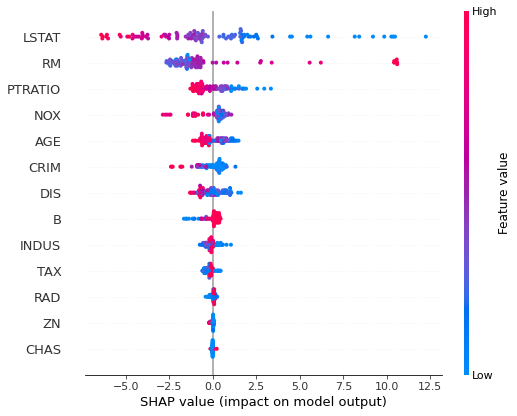

In [11]:
# plot the feature importance
shap.summary_plot(shap_values, x_test)

From the summary plot above, we could see the **most important features** sorted by their importance level. It tells us that regions with less lower status population, higher median number of rooms and less pupil-teacher ratio will have a higher housing price. It's also in line with what we learnt from Linear Regression above.

### Partial Dependence Plot -- Statistical relationship between share of Black residents and housing price

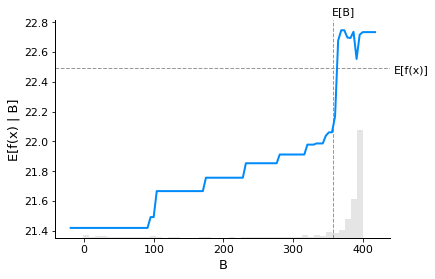

In [12]:
shap.plots.partial_dependence(
    "B",
    fitted_model.predict,
    pd.DataFrame(boston_data.data, columns=boston_data.feature_names),
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

Taking share of Black residents as an example, here `B` is a function of Black population in town, the higher of `B`, the lower of Black population(%). From the coefficient of linear regression, the shap summary plot and also the partial dependence plot, we could get the same conclusion that there is a positive correlation between `B` and median housing price. In other word, housing price will decrease with the increasing of Black population(%). However, is that really **causal**? One would hope that today race would not be a driver of housing prices, let us validate that in the following section. 

Overall, all the insights above are coming from **corelation** perspective, telling us the positive or negative correlation between each predictor and the target. In order to correctly find the **casusal** relationship, we have to train a different model controlling on all the possible **hidden variables (confounders)** and learn the **direct causal effect** for a given feature. That's what the causal interpretation tool is doing. In the following section, we will explore the causal relationship in different ways.

# Causal Interpretation
### Direct Causal Effect --  Do the top predictors also have a direct effect on outcome of interest?

In [13]:
classification = False
# order feature names according to shap values
vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(
    list(zip(shap_values.feature_names, vals)), columns=["features", "importance"]
)
feature_importance.sort_values(by=["importance"], ascending=False, inplace=True)
top_features = feature_importance["features"]

In [14]:
from econml.solutions.causal_analysis import CausalAnalysis

ca = CausalAnalysis(
    top_features,
    categorical,
    heterogeneity_inds=None,
    classification=classification,
    nuisance_models="automl",
    heterogeneity_model="linear",
    n_jobs=-1,
)
ca.fit(pd.DataFrame(x_train, columns=boston_data.feature_names), y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   39.5s finished


In [15]:
# get global causal effect ordered by causal importance (pvalue)
global_summ = ca.global_causal_effect(alpha=0.05)
global_summ.sort_values(by="p_value")

,,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,feature_value,,,,,,
RM,num,4.485013,0.393063,11.410413,3.709629e-30,3.714623,5.255403
LSTAT,num,-0.453959,0.085578,-5.304642,1.128945e-07,-0.621689,-0.286230
CHAS,1.0v0.0,5.543213,1.467013,3.778572,1.577304e-04,2.667921,8.418505
CRIM,num,-0.879726,0.325176,-2.705381,6.822610e-03,-1.517060,-0.242392
INDUS,num,-0.456560,0.213203,-2.141432,3.223922e-02,-0.874431,-0.038690
AGE,num,-0.028304,0.020316,-1.393223,1.635523e-01,-0.068122,0.011514
NOX,num,-8.422913,6.135515,-1.372813,1.698106e-01,-20.448302,3.602476
PTRATIO,num,-0.933123,0.727840,-1.282045,1.998268e-01,-2.359662,0.493416
DIS,num,-0.484512,0.416718,-1.162683,2.449580e-01,-1.301265,0.332242


In [16]:
# helper function to plot error bar
def errorbar(res):
    xticks = res.index.get_level_values(0)
    lowererr = res["point"] - res["ci_lower"]
    uppererr = res["ci_upper"] - res["point"]
    xticks = [
        "{}***".format(t)
        if p < 1e-6
        else ("{}**".format(t) if p < 1e-3 else ("{}*".format(t) if p < 1e-2 else t))
        for t, p in zip(xticks, res["p_value"])
    ]
    plot_title = "Direct Causal Effect of Each Feature with 95% Confidence Interval, "
    plt.figure(figsize=(15, 5))
    plt.errorbar(
        np.arange(len(xticks)),
        res["point"],
        yerr=[lowererr, uppererr],
        fmt="o",
        capsize=5,
        capthick=1,
        barsabove=True,
    )
    plt.xticks(np.arange(len(xticks)), xticks, rotation=45)
    plt.title(plot_title)
    plt.axhline(0, color="r", linestyle="--", alpha=0.5)
    plt.ylabel("Average Treatment Effect")

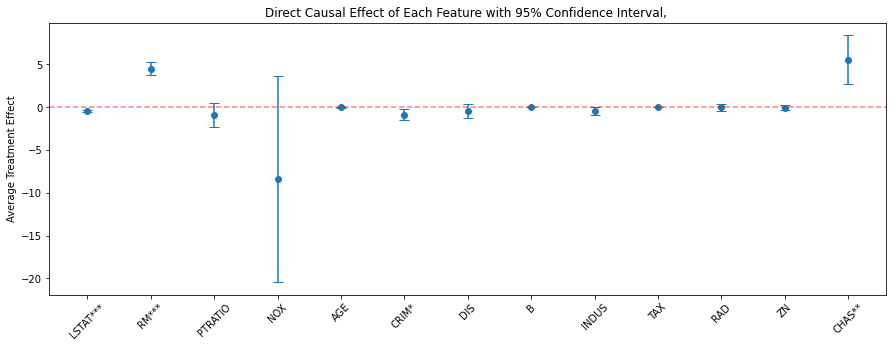

In [17]:
errorbar(global_summ)

We learn the **Average Treatment Effect (ATE)** for each feature, assuming they are the treatment. The error bar above is ordered by **feature importance**, and the summary table above is ordered by **causal significance (p-value)**. You could see they are not exact in the same order. Some top features such as percentage of lower status population (`LSTAT`) and number of rooms (`RM`), they are the strongest predictors and also have a direct causal effect on housing price, but others like pupil-teacher ratio (`PTRATIO`) and nitric oxides concentration (`NOX`) they don't really have significant causal effect on housing price. Also on the other side features like whether in Charles River Area (`CHAS`), it doesn't have strong prediction power comparing with others features, but it has a direct causal effect. 

Following on the findings we learnt for share of Black residents (`B`), we could see it also gives us insignificant causal effect on housing price, which means race is not a direct driver. Using the causal analysis tool has helped us avoid reaching a controversial and incorrect conclusion. 

To sum up, EonML could give us some extra insights from **causal relationship** perspective.

### Segmentation -- How different type of houses respond differently to number of rooms?
From the analysis above, we learnt the direct treatment effect of each feature from an overall average level. However, different regions might respond differently on housing price for each potential driver. In the following section, we are going to use number of rooms (`RM`) as an example to learn how different type of houses respond differently to number of rooms? 

In [18]:
local_summ = ca.local_causal_effect(x_test)

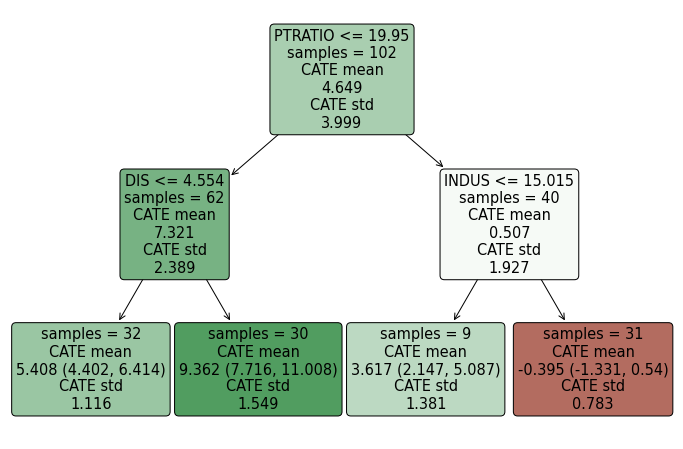

In [19]:
plt.figure(figsize=(12, 8))
ca.plot_heterogeneity_tree(
    pd.DataFrame(x_test, columns=boston_data.feature_names),
    "RM",
    max_depth=2,
    min_impurity_decrease=1e-6,
)

From the global level, we know that the ATE of `RM` is 4.48, which means in average adding one more room will raise the housing price by 4.48 unit. In the shallow tree above, we could see although overall `RM` has a significant positive effect on housing price, but housing price will be more expensive for one more room in regions with lower pupil-teather rate, and the effect will be insignificant in the regions with higher pupil-teather rate and lower retail business rate. 

### What If Analysis - How the overall housing price changes with one more room?
The causal analysis tool could also answer **what if** types of questions. For a given treatment, we'd also like to know the **counterfactuals** if we intervene it in a different way. In the example below, we will learn how the overall housing price changes with one more room?

In [20]:
print("current average housing price on test set: ", y_test.mean())
cf = ca.whatif(x_test, x_test[:, 5] + 1, 5, y_test)
cf.population_summary()

current average housing price on test set:  22.21960784313725


Text(0.5, 1.0, 'Histogram of Housing price -- Current vs. One more room')

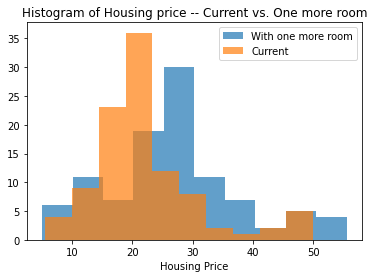

In [21]:
# distribution comparison
plt.hist(cf.point_estimate, label="With one more room", alpha=0.7)
plt.hist(y_test, label="Current", alpha=0.7)
plt.legend()
plt.xlabel("Housing Price")
plt.title("Histogram of Housing price -- Current vs. One more room")

From the summary table we could see overall if we add one more room in the test set, the housing price will increase by 4+ units, which is in line with the ATE we learnt above. And the histrogram shows a comparison between the current housing price distribution and the counterfactuals ditribution if we add one more room.